# German License Plate Recognition - Data Collection & Exploration
    
This notebook explains the data collection used for the License Recognition model and prepares the data for training.

Main steps:
- Generate German license plate images
- Create a hdf5 dataset (glp.h5) with plate images
- Create a ddf5 dataset (background.h5) with arbitrary background images, used for data augementation

The following diagram shows the directory structure that is created when executing the individual steps of this notebook:

```
<project_dir>
│   :   :
├── data
│   ├── license_recognition
│   │   ├── plate_images
│   │   │   ├── A-CR655.jpg
│   │   │   ├── A-MB1012.jpg
│   │   │   :
│   │   ├── test_images
│   │   ├── german_states.json
│   │   ├── KFZ-Deutschland-2017-06-20.csv
│   │   ├── background.h5
│   │   ├── glp.h5
:   :   :
```

Import common modules...

In [1]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import json
import os.path
import random
import re
import time
import cv2
import requests
import pandas as pd
import progressbar
import tarfile
import zipfile
import matplotlib
import requests

from google_drive_downloader import GoogleDriveDownloader as gdd
from imutils import paths
from PIL import Image

from config.license_recognition import config

# License Plate Dataset

Germany is divided into 16 federal states, which in turn are divided into different districts. For each of the districts there are one or more different distinguishing marks consisting of 1 to 3 letters, such as B for Berlin or D for Düsseldorf. There are currently 660 different distinguishing marks, see German car plates. See [deutsche-autokennzeichen](https://laenderkennzeichen.net/deutsche-autokennzeichen/).

A car license plate consists of the distinctive mark and an identification number of 1 to 2 letters and up to 4 digits such as AB 1234. Between the distinguishing mark and the identification number is the inspection sticker of the last main inspection (HU) as well as the stamp sticker of the licensing authority with its seal and the state. See [Autokennzeichen.de](https://autokennzeichen.de/kennzeichen-aufbau/).

**Example:**

![](documentation/license_plate.png)

First we have to provide the data collections needed for the training. With the following command we download the data collection from Google Drives to our local project directory and unzip it there.

In [3]:
gdd.download_file_from_google_drive(file_id='1wfOXLXMvmcj-rLsyJXmZ8sIOCo0YlaCE',
                                    dest_path='data/license_recognition.zip',
                                    unzip=True)

Unzipping...Done.


Load the 16 German federal states into a pandas data frame...

In [4]:
states_df = pd.read_json("data/license_recognition/german_states.json")
print (states_df)

    CM                   DESCR
0   BE                  Berlin
1   BB             Brandenburg
2   BW       Baden-Württemberg
3   BY                  Bayern
4   HB                  Bremen
5   HH                 Hamburg
6   HE                  Hessen
7   MV  Mecklenburg-Vorpommern
8   NI           Niedersachsen
9   NW     Nordrhein-Westfalen
10  RP         Rheinland-Pfalz
11  SH      Schleswig-Holstein
12  SL                Saarland
13  SN                 Sachsen
14  ST          Sachsen-Anhalt
15  TH               Thüringen


Load German distinguishing marks into a pandas data frame...

In [3]:
states_dict = states_df.set_index('DESCR').to_dict()['CM']

counties_df = pd.read_csv("data/license_recognition/KFZ-Deutschland-2017-06-20.csv", delimiter=';')

counties_df['Autokennzeichen'] = counties_df['Autokennzeichen'].str.replace('*','')
counties_df['Bundesland'] = counties_df['Bundesland'].str.split(' ').str[0]

counties_df.insert(1,'State', counties_df['Bundesland'].replace(states_dict))

print ('Number of distinguishing marks: {}'.format(len(counties_df['Autokennzeichen'])))

counties_df.head(30)

Number of distinguishing marks: 660


,Autokennzeichen,State,Stadt/Ort,Landkreis/Gemeinde,Bundesland
0,A,BY,Augsburg,Stadt & Landkreis Augsburg,Bayern
1,AA,BW,Aalen,Ostalbkreis,Baden-Württemberg
2,AB,BY,Aschaffenburg,Landkreis & Stadt Aschaffenburg,Bayern
3,ABG,TH,Altenburg,Landkreis Altenburger Land,Thüringen
4,ABI,ST,Anhalt-Bitterfeld,Landkreis Anhalt-Bitterfeld,Sachsen-Anhalt
5,AC,NW,Aachen,Städteregion Aachen,Nordrhein-Westfalen
6,AE,SN,Auerbach im Vogtland,Vogtlandkreis,Sachsen
7,AH,NW,Ahaus,Kreis Borken,Nordrhein-Westfalen
8,AIB,BY,Bad Aibling,Landkreise München & Rosenheim,Bayern
9,AIC,BY,Aichach,Landkreis Aichach-Friedberg,Bayern


Create a license plate image generator, which generates images of car license plates from randomly generated car licenses, taking into account the regulations for German license plates. The generator uses the [heisnbrg.net](http://nummernschild.heisnbrg.net/fe/) web service to generate an image from a car license number.

The generator observes the following criteria:

- Valid distinguishing marks
- Use only valid characters
- Compliance with format and length restrictions
- TÜV badge (year/month)
- Badge for federal state under consideration of the distinguishing mark
- Generates an image for the front and one for the rear license plate for each license number

Since the color is not particularly relevant for number plate recognition, the generator saves the generated images as gray images, which saves memory and computing time during processing.

In [4]:
class GermanLicensePlateImagesGenerator:
    def __init__(self, counties_df, output_folder):
        self.output_folder = output_folder
        self.counties_df = counties_df
        self.LETTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZÄÖÜ"
        self.DIGITS = "0123456789"
        self.MONTHS = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
        self.YEARS = ['06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17']

        random.seed()

    @staticmethod
    def get_image_url(license_number, state, month, year):
        license_number = license_number.replace("-", "%3A").replace("Ä", "%C4").replace("Ö", "%D6").replace("Ü", "%DC")
        return "http://nummernschild.heisnbrg.net/fe/task?action=startTask&kennzeichen={0}&kennzeichenZeile2=&engschrift=false&pixelHoehe=32&breiteInMM=520&breiteInMMFest=true&sonder=FE&dd=01&mm=01&yy=00&kreis={1}&kreisName=&humm={2}&huyy={3}&sonderKreis=LEER&mm1=01&mm2=01&farbe=SCHWARZ&effekt=KEIN&tgaDownload=false".format(
            license_number, state, month, year)

    def generate_license_number(self, county):
        letter_count = random.randint(1, 2)
        letters = "{}".format(random.choice(self.LETTERS)) if letter_count == 1 else "{}{}".format(
            random.choice(self.LETTERS), random.choice(self.LETTERS))

        min = 1 if letter_count == 2 else 1
        digit_count = random.randint(min, max((8 - len(county) - letter_count), 4))
        digits = ""
        for i in range(digit_count):
            digits += random.choice(self.DIGITS)

        return "{}-{}{}".format(county, letters, digits)

    def create_license_plate_image(self, license_number, state, front):
        file_path = os.path.join(self.output_folder, '{0}#{1}.png'.format("F" if front else "R", license_number))
        if os.path.exists(file_path):
            return False

        month = random.choice(self.MONTHS) if front else ''
        year = random.choice(self.YEARS) if front else ''

        create_image_url = GermanLicensePlateImagesGenerator.get_image_url(license_number, state, month, year)
        r = requests.get(create_image_url)
        if r.status_code != 200:
            return False

        id = re.compile('<id>(.*?)</id>', re.DOTALL | re.IGNORECASE).findall(
            r.content.decode("utf-8"))[0]

        status_url = 'http://nummernschild.heisnbrg.net/fe/task?action=status&id=%s' % id
        time.sleep(.200) # wait a short time to not overload the webservice
        r = requests.get(status_url)
        if r.status_code != 200:
            return False

        show_image_url = 'http://nummernschild.heisnbrg.net/fe/task?action=showInPage&id=%s'
        show_image_url = show_image_url % id
        time.sleep(.200) # wait a short time to not overload the webservice
        r = requests.get(show_image_url)
        if r.status_code != 200:
            return False

        # sometimes the web service returns a corrupted image, check the image by getting the size and skip if corrupted
        try:
            numpyarray = np.frombuffer(r.content, dtype=np.uint8)
            image = cv2.imdecode(numpyarray, cv2.IMREAD_COLOR)
            return Image.fromarray(image)  # don't use cv2.imwrite() because there is a bug with utf-8 encoded filepaths
        except:
            return None

    def generate(self, items):
        for n in range(items):
            while True:
                sample = self.counties_df.sample(1)                
                county = sample.Autokennzeichen.values[0]
                state  = sample.State.values[0]

                license_number = self.generate_license_number(county)
               
                file_name = '{0}#{1}.png'.format("F", license_number)
                file_path = os.path.join(self.output_folder, file_name)
                if os.path.exists(file_path):
                    continue
                
                image = self.create_license_plate_image(license_number, state, True)
                image = image.convert('L')
                if not image is None:
                    image.save(file_path)
                    print("{0:06d} : {1}".format(n+1, file_name))

                time.sleep(.200)

                file_name = '{0}#{1}.png'.format("R", license_number)
                file_path = os.path.join(self.output_folder, file_name)
                if os.path.exists(file_path):
                    continue

                image = self.create_license_plate_image(license_number, state, False)
                image = image.convert('L')
                if not image is None:
                    image.save(file_path)
                    print("{0:06d} : {1}".format(n+1, file_name))

                time.sleep(.200)
                break

                
lpig = GermanLicensePlateImagesGenerator(counties_df, "data/license_recognition/plate_images")

Example of a generated front and rear license plate, each as a color and a gray image.

County:  LA
State:   BY
License: LA-AP4471


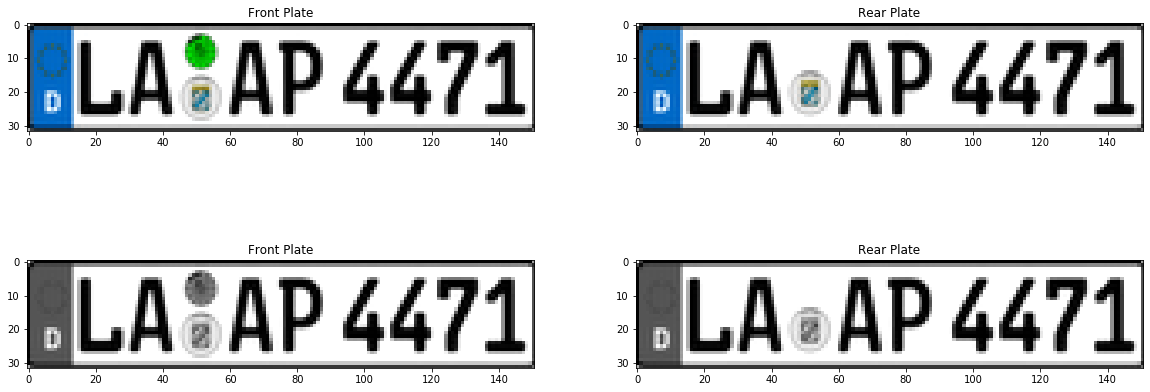

In [8]:
def generate_plate_images():
    sample = lpig.counties_df.sample(1)           
    county = sample.Autokennzeichen.values[0]
    state  = sample.State.values[0]

    print ("County:  {}".format(county))
    print ("State:   {}".format(state))
 
    license_number = lpig.generate_license_number(county)
    print ("License: {}".format(license_number))

    front_image = lpig.create_license_plate_image(license_number, state, True)
    rear_image = lpig.create_license_plate_image(license_number, state, False)
    return np.array(front_image), np.array(rear_image)
    

front_image, rear_image = generate_plate_images()

fig=plt.figure(figsize=(20, 8))

ax = fig.add_subplot(2,2,1)
plt.imshow(cv2.cvtColor(front_image, cv2.COLOR_BGR2RGB))
ax.set_title("Front Plate")
ax =fig.add_subplot(2,2,2)
plt.imshow(cv2.cvtColor(rear_image, cv2.COLOR_BGR2RGB))
ax.set_title("Rear Plate")

ax = fig.add_subplot(2,2,3)
plt.imshow(cv2.cvtColor(front_image, cv2.COLOR_BGR2GRAY), cmap="gray")
ax.set_title("Front Plate")
ax = fig.add_subplot(2,2,4)
plt.imshow(cv2.cvtColor(rear_image, cv2.COLOR_BGR2GRAY), cmap="gray")
ax.set_title("Rear Plate")

plt.show()

In the next step we create the license plate images for our data collection. Here we only generate the images for 30 license plates for demonstration. 

To create the final data collection, Approximately 70.000 images should be used, this takes approximately 20 hours.

In [9]:
os.makedirs("data/license_recognition/plate_images", exist_ok=True)

lpig.generate(30)

000001 : F#BIN-N3.png
000001 : R#BIN-N3.png
000002 : F#SE-R0362.png
000002 : R#SE-R0362.png
000003 : F#MW-VP89.png
000003 : R#MW-VP89.png
000004 : F#WL-JP7646.png
000004 : R#WL-JP7646.png
000005 : F#BO-A68.png
000005 : R#BO-A68.png
000006 : F#WND-LT6991.png
000006 : R#WND-LT6991.png
000007 : F#HHM-UM782.png
000007 : R#HHM-UM782.png
000008 : F#LSN-JY1.png
000008 : R#LSN-JY1.png
000009 : F#GR-L2.png
000009 : R#GR-L2.png
000010 : F#ES-S54.png
000010 : R#ES-S54.png
000011 : F#THL-BT7.png
000011 : R#THL-BT7.png
000012 : F#WR-JK91.png
000012 : R#WR-JK91.png
000013 : F#SLE-DW906.png
000013 : R#SLE-DW906.png
000014 : F#BIT-X133.png
000014 : R#BIT-X133.png
000015 : F#WW-SJ704.png
000015 : R#WW-SJ704.png
000016 : F#A-QG93.png
000016 : R#A-QG93.png
000017 : F#PI-AI1293.png
000017 : R#PI-AI1293.png
000018 : F#SHK-LY0.png
000018 : R#SHK-LY0.png
000019 : F#GÜ-FM99.png
000019 : R#GÜ-FM99.png
000020 : F#SZ-F174.png
000020 : R#SZ-F174.png
000021 : F#PE-ÄJ39.png
000021 : R#PE-ÄJ39.png
000022 : F#SO-EW73

For easier and faster processing of the images during training, we create an HDF5 data set from the images, which offers easy access and significantly reduces the I/O load during training, thus accelerating the training process.

Building the HDF5 data set takes few minutes...

In [11]:
from utils.io import HDF5DatasetWriter
from imutils import paths

DATASET_PATH = "data/license_recognition/glp.h5"

# read image paths and labels
paths = list(paths.list_images('data/license_recognition/plate_images'))
labels = [p.split(os.path.sep)[-1].split(".")[0].split('#')[1] for p in paths]

# original size of generated license plate images
IMAGE_WIDTH = 151
IMAGE_HEIGHT = 32

# create HDF5 writer
print("[INFO] building {}...".format(DATASET_PATH))
writer = HDF5DatasetWriter((len(paths), IMAGE_HEIGHT, IMAGE_WIDTH), DATASET_PATH)

# initialize the progress bar
widgets = ["Building Dataset: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(paths), widgets=widgets)
pbar.start()

# loop over the image paths
for (i, (path, label)) in enumerate(zip(paths, labels)):
    # load the image and process it
    # image = cv2.imread(path, cv2.IMREAD_COLOR)  # don't use imread because bug with utf-8 paths
    stream = open(path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)

    try:
        image = cv2.imdecode(numpyarray, cv2.IMREAD_GRAYSCALE)
    except:
        print("[ERROR] open image failed: %s" % path)
        continue

    # check image size
    if not image.shape == (IMAGE_HEIGHT, IMAGE_WIDTH):
        print("[ERROR] image with wrong size: %s" % path)
        continue

    # check number length
    if len(label) > 10:
        print("[ERROR] image with wrong label: %s - %s" % (path, label))
        continue

    # add the image and label # to the HDF5 images
    writer.add([image], [label])
    pbar.update(i)

# close the HDF5 writer
pbar.finish()
writer.close()

print("[INFO] {} successfully created".format(DATASET_PATH))

[INFO] building data/license_recognition/glp.h5...
[INFO] data/license_recognition/glp.h5 successfully created


Load and explore the license plate data set...

In [12]:
from utils.io import Hdf5DatasetLoader

loader = Hdf5DatasetLoader()
plate_images = loader.load('data/license_recognition/glp.h5', shuffle=True)

print ('Image count: {}'.format(len(plate_images[0])))

Image count: 60


Here is an excerpt from the generated images ...

In [2]:
def show_images(images, labels, figsize=(15, 5)):
    cols = 5
    rows = len(images) // cols

    image_index = 0
    fig, axarr = plt.subplots(rows, cols, figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            image = images[image_index]
            axarr[r, c].axis("off")
            axarr[r, c].title.set_text(labels[image_index])
            axarr[r, c].imshow(image, cmap='gray')
            image_index += 1

    plt.show()

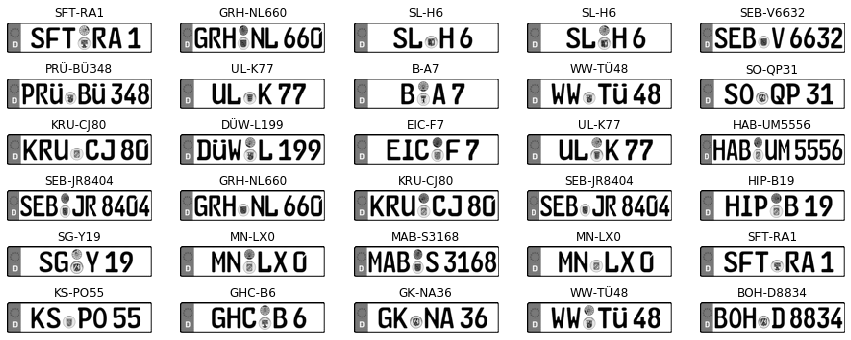

In [12]:
show_images(plate_images[0][:30], plate_images[1][:30], figsize=(15, 6))

# Background Dataset
For data augmentation we need as many different background images as possible. We create this by randomly extracting 100,000 images from the [SUN2012](https://groups.csail.mit.edu/vision/SUN/) data set and creating an HDF5 data set.

Depending on the system environment, [wget](https://eternallybored.org/misc/wget/) must be installed to perform the following step! It may take a few minutes to download the SUN2012 data set...

In [7]:
%%bash
wget http://groups.csail.mit.edu/vision/SUN/releases/SUN2012.tar.gz -P data/license_recognition

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
import tarfile
from utils.io import HDF5DatasetWriter

ITEMS = 100000

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

def im_from_file(f):
    a = np.asarray(bytearray(f.read()), dtype=np.uint8)
    return cv2.imdecode(a, cv2.IMREAD_GRAYSCALE)


def create_background_dataset(archive_name, output_path, max_items=np.inf):
    print("[INFO] reading content of {}...".format(archive_name))
    tar = tarfile.open(name=archive_name)
    files = [
        tarinfo for tarinfo in tar.getmembers()
        if tarinfo.name.startswith("./SUN2012/Images/") and tarinfo.name.endswith(".jpg")
    ]

    # create shuffled index list
    randomized_indexes = np.arange(len(files))
    np.random.shuffle(randomized_indexes)

    # pick max number of items
    if max_items == np.inf or max_items > len(files):
        max_items = len(files)

    randomized_indexes = randomized_indexes[0:max_items]

    print("[INFO] building {}...".format(output_path))
    writer = HDF5DatasetWriter((len(randomized_indexes), IMAGE_HEIGHT, IMAGE_WIDTH), output_path)

    widgets = ["Building Dataset: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(randomized_indexes), widgets=widgets).start()
    index = 0

    for i, file in enumerate(files):

        if i not in randomized_indexes:
            continue

        f = tar.extractfile(file)
        if f is None:
            continue  # skip directories
        try:
            image = im_from_file(f)
        finally:
            f.close()
        if image is None:
            continue  # skip non image files

        # make same width and height, by cutting the larger dimension to the smaller dimension
        if image.shape[0] > image.shape[1]:
            image = image[:image.shape[1], :]
        else:
            image = image[:, :image.shape[0]]

        # resize to target-width and -height, keeping the aspect ratio
        if image.shape[0] != IMAGE_HEIGHT:
            image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

        # name from index
        name = "{:08}".format(index)

        # check image size
        if not image.shape == (IMAGE_HEIGHT, IMAGE_WIDTH):
            print("image with wrong size: %s" % name)
            continue

        # add the image and name to the HDF5 db
        writer.add([image], [name])
        pbar.update(index)
        index += 1

    # close the HDF5 writer
    pbar.finish()
    writer.close()
    print("[INFO] {} images saved to {}...".format(len(randomized_indexes), output_path))


create_background_dataset('data/license_recognition/SUN2012.tar.gz', 'data/license_recognition/background.h5', ITEMS)


[INFO] reading content of data/SUN2012.tar.gz...


[INFO] building data/background.h5...


Building Dataset: 100% |########################################| Time: 0:02:03


[INFO] 16873 images saved to data/background.h5...


Now we can load the HDF5 background dataset and display some sample images...

In [2]:
from utils.io import Hdf5DatasetLoader

loader = Hdf5DatasetLoader()
background_images = loader.load('data/license_recognition/background.h5', shuffle=True, max_items=10000)

print ('{} background images'.format(len(background_images[0])))

10000 background images


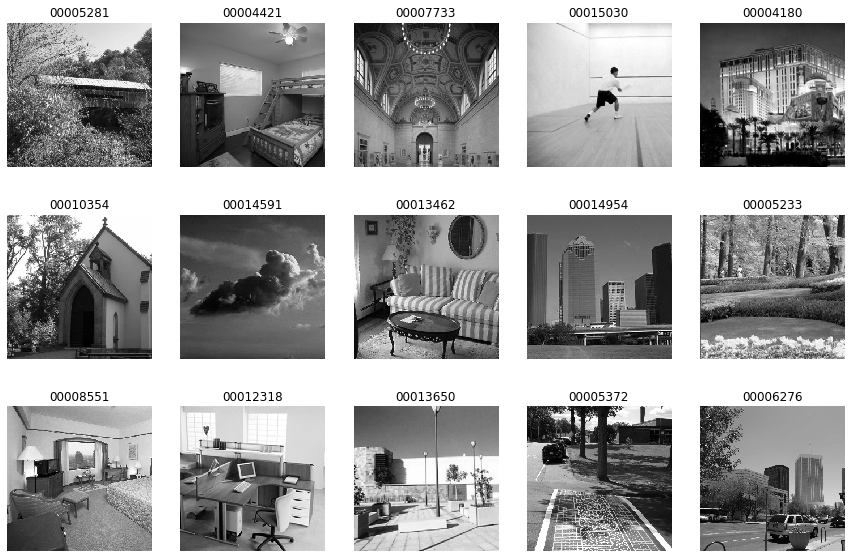

In [14]:
show_images(background_images[0][:15], background_images[1][:15], figsize=(15, 10))